**CUNY-Specific Analytics**
1. Which MTA bus routes are highly utilized by CUNY students?
2. How do violation rates compare among CUNY campuses?
--- 
This data specifically focuses on 2025 (Jan-Aug) as these questions place on emphasis on current campuses and students. 


In [97]:
import requests
import io
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from pathlib import Path

**Data loading/cleaning** - MTA Bus Ridership (currently using beginning of 2025 dataset)

In [82]:
ridership_endpoint = "https://data.ny.gov/resource/gxb3-akrn.csv"

def fetch_ridership_for_routes(route_list, start_date="2025-01-01", end_date="2025-08-31"):
    ridership_frames = []
    chunk_size = 300 

    for i in range(0, len(route_list), chunk_size):
        chunk = route_list[i:i+chunk_size]
        routes_str = ",".join([f"'{r}'" for r in chunk])

        params = {
            "$select": "bus_route, sum(ridership) as total_ridership",
            "$where": f"bus_route in ({routes_str}) AND transit_timestamp between '{start_date}T00:00:00' and '{end_date}T23:59:59'",   # filters only jan-aug 2025 data
            "$group": "bus_route",
            "$limit": 50000
        }

        # query API
        resp = requests.get(ridership_endpoint, params=params)
        resp.raise_for_status()

        # read response into pandas
        df_chunk = pd.read_csv(io.StringIO(resp.text))
        ridership_frames.append(df_chunk)

    return pd.concat(ridership_frames, ignore_index=True)


**Data loading/cleaning** - CUNY campuses

In [83]:
url = "https://data.ny.gov/resource/irqs-74ez.csv"
campuses = pd.read_csv(url)
campuses.head() 

,college_or_institution_type,campus,campus_website,address,city,state,zip,lat,long,georeference
0,Community Colleges,Borough of Manhattan Community College,https://www.bmcc.cuny.edu/,199 Chambers Street,New York,NY,10007-1044,40.717367,-74.012178,POINT (-74.012178 40.717367)
1,Community Colleges,Bronx Community College,https://www.bcc.cuny.edu/,2155 University Avenue,Bronx,NY,10453-2804,40.856673,-73.910127,POINT (-73.910127 40.856673)
2,Community Colleges,Hostos Community College,http://hostos.cuny.edu,500 Grand Concourse,Bronx,NY,10451-5323,40.817828,-73.926862,POINT (-73.926862 40.817828)
3,Community Colleges,Kingsborough Community College,http://kbcc.cuny.edu,2001 Oriental Boulevard,Brooklyn,NY,11235-2333,40.578349,-73.934465,POINT (-73.934465 40.578349)
4,Community Colleges,LaGuardia Community College,https://www.laguardia.edu/,31-10 Thomson Avenue,Long Island City,NY,11101-3007,40.743951,-73.935154,POINT (-73.935154 40.743951)


In [84]:
campuses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   college_or_institution_type  26 non-null     object 
 1   campus                       26 non-null     object 
 2   campus_website               26 non-null     object 
 3   address                      26 non-null     object 
 4   city                         26 non-null     object 
 5   state                        26 non-null     object 
 6   zip                          26 non-null     object 
 7   lat                          26 non-null     float64
 8   long                         26 non-null     float64
 9   georeference                 26 non-null     object 
dtypes: float64(2), object(8)
memory usage: 2.2+ KB


In [85]:
campuses[['campus', 'lat', 'long']]

,campus,lat,long
0,Borough of Manhattan Community College,40.717367,-74.012178
1,Bronx Community College,40.856673,-73.910127
2,Hostos Community College,40.817828,-73.926862
3,Kingsborough Community College,40.578349,-73.934465
4,LaGuardia Community College,40.743951,-73.935154
5,Queensborough Community College,40.756150,-73.757550
6,Guttman Community College,40.752846,-73.984133
7,Medgar Evers College,40.666240,-73.957349
8,New York City College of Technology,40.695507,-73.987882
9,College of Staten Island,40.608648,-74.153563


In [86]:
# borough mapping for all CUNY campuses
borough_map = {
    "Borough of Manhattan Community College": "Manhattan",
    "Bronx Community College": "Bronx",
    "Hostos Community College": "Bronx",
    "Kingsborough Community College": "Brooklyn",
    "LaGuardia Community College": "Queens",
    "Queensborough Community College": "Queens",
    "Guttman Community College": "Manhattan",
    "Medgar Evers College": "Brooklyn",
    "New York City College of Technology": "Brooklyn",
    "College of Staten Island": "Staten Island",
    "School of Labor and Urban Studies": "Manhattan",
    "School of Law": "Queens",
    "The Graduate School and University Center": "Manhattan",
    "School of Professional Studies": "Manhattan",
    "School of Public Health": "Manhattan",
    "School of Journalism": "Manhattan",
    "Macaulay Honors College": "Manhattan",
    "Baruch College": "Manhattan",
    "Brooklyn College": "Brooklyn",
    "The City College of New York": "Manhattan",
    "School of Medicine": "Manhattan",
    "Hunter College": "Manhattan",
    "John Jay College of Criminal Justice": "Manhattan",
    "Lehman College": "Bronx",
    "Queens College": "Queens",
    "York College": "Queens"
}

campuses["borough"] = campuses["campus"].map(borough_map)

# clean list of all campuses (will be used later to ensure 0 values show up)
all_campuses = campuses[["campus", "borough"]].rename(columns={"campus": "campus_name"})

In [87]:
# conversion for gpd - mapping
campuses['geometry'] = campuses.apply(lambda row: Point(row['long'], row['lat']), axis=1)
campuses_gdf = gpd.GeoDataFrame(campuses, geometry='geometry', crs="EPSG:4326")


**Data loading/cleaning** - Bus stops/routes

In [88]:
# GTFS dataset
GTFS_ROOT = Path("../raw_data")

feeds = {"bronx": "gtfs_bronx",
         "brooklyn": "gtfs_brooklyn",
         "manhattan": "gtfs_manhattan",
         "queens": "gtfs_queens",
         "staten_island": "gtfs_staten_island",
         "busco": "gtfs_busco"}

def load_concat(file_name):
    frames = []
    for key, sub in feeds.items():
        p = GTFS_ROOT / sub / file_name
        if p.exists():
            df = pd.read_csv(p)
            df["feed"] = key
            frames.append(df)
    if not frames:
        raise FileNotFoundError(f"Could not find {file_name} in any of the feed folders")
    return pd.concat(frames, ignore_index=True)

stops = load_concat("stops.txt")
routes = load_concat("routes.txt")
trips = load_concat("trips.txt")
stop_times = load_concat("stop_times.txt")

print(stops.shape, routes.shape, trips.shape, stop_times.shape)
stops.head()

(14456, 10) (1532, 10) (230451, 8) (7447673, 9)


,stop_id,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,feed
0,100014,BEDFORD PK BLVD/GRAND CONCOURSE,NaN,40.872562,-73.888156,NaN,NaN,0.0,NaN,bronx
1,100017,PAUL AV/W 205 ST,NaN,40.876836,-73.889710,NaN,NaN,0.0,NaN,bronx
2,100018,PAUL AV/WEST MOSHOLU PKWY SOUTH,NaN,40.880392,-73.886081,NaN,NaN,0.0,NaN,bronx
3,100019,GRAND CONCOURSE/E 138 ST,NaN,40.813496,-73.929489,NaN,NaN,0.0,NaN,bronx
4,100020,GRAND CONCOURSE/E 144 ST,NaN,40.816812,-73.928001,NaN,NaN,0.0,NaN,bronx


In [89]:
# conversion for gpd - mapping
stops_gdf = gpd.GeoDataFrame(stops.assign(geometry=[Point(xy) for xy in zip(stops["stop_lon"],
            stops["stop_lat"])]),
            geometry="geometry",
            crs="EPSG:4326")

**Lookup for which routes serve which stops**

In [90]:
# cleaning columns presented
stop_times_small = stop_times[["trip_id", "stop_id"]]
trips_small = trips[["trip_id", "route_id"]]

stops_to_route = (stop_times_small.merge(trips_small, on="trip_id", how="inner").drop_duplicates(subset=["stop_id", "route_id"]))
stops_to_route.head()

,trip_id,stop_id,route_id
0,GH_O5-Weekday-033300_BX238_608,101734,BX26
1,GH_O5-Weekday-033300_BX238_608,101735,BX26
2,GH_O5-Weekday-033300_BX238_608,104619,BX26
3,GH_O5-Weekday-033300_BX238_608,101737,BX26
4,GH_O5-Weekday-033300_BX238_608,101738,BX26


**Routes Near CUNY Campuses** - Dynamic buffer based on campus size

In [91]:
# dynamic buffer sizes (in meters) determined by general campus size
buffer_dict = {
    "Borough of Manhattan Community College": 400,
    "Bronx Community College": 600,
    "Hostos Community College": 400,
    "Kingsborough Community College": 800,
    "LaGuardia Community College": 500,
    "Queensborough Community College": 700,
    "Guttman Community College": 300,
    "Medgar Evers College": 500,
    "New York City College of Technology": 400,
    "College of Staten Island": 1000,
    "School of Labor and Urban Studies": 300,
    "School of Law": 400,
    "The Graduate School and University Center": 300,
    "School of Professional Studies": 300,
    "School of Public Health": 300,
    "School of Journalism": 300,
    "Macaulay Honors College": 300,
    "Baruch College": 400,
    "Brooklyn College": 700,
    "The City College of New York": 700,
    "School of Medicine": 400,
    "Hunter College": 400,
    "John Jay College of Criminal Justice": 400,
    "Lehman College": 700,
    "Queens College": 800,
    "York College": 600
}

# conversion to meters (for buffer)
campuses_meters = campuses_gdf.to_crs(3857)
stops_meters = stops_gdf.to_crs(3857)

# if campus is not in dictionary, fall back to 500m
campus_buffers = campuses_meters.copy()
campus_buffers["geometry"] = campuses_meters.apply(
    lambda row: row["geometry"].buffer(buffer_dict.get(row["campus"], 500)),
    axis=1
)

# checking which stops fall inside each campus buffer
stops_near_campus = gpd.sjoin(stops_meters, campus_buffers[["campus", "geometry"]], how="inner", predicate="within")
stops_near_campus = stops_near_campus.rename(columns={"campus":"campus_name"})

# conversion back to latitude/longitude
stops_near_campus = stops_near_campus.to_crs(4326)

In [92]:
# mapping stops -> routes then aggregating routes per campus
routes_near_campus = (stops_near_campus[["stop_id", "campus_name"]]
                      .merge(stops_to_route, on="stop_id", how="left")
                      .dropna(subset=["route_id"])
                      .merge(routes[["route_id", "route_short_name", "route_long_name"]], on="route_id", how="left")
                      .drop_duplicates(subset=["campus_name", "route_id"])
                      )

# show top routes per campus
top_routes_by_campus = (stops_near_campus[["stop_id", "campus_name"]]
                         .merge(stops_to_route, on="stop_id", how="left")
                         .dropna(subset=["route_id"])
                         .groupby(["campus_name", "route_id"])
                         .size().reset_index(name="nearby_stop_count")
                         .sort_values(["campus_name", "nearby_stop_count"], ascending=[True,False])
                         )

top_routes_by_campus.head()

,campus_name,route_id,nearby_stop_count
27,Baruch College,X37,17
28,Baruch College,X38,17
0,Baruch College,BM1,15
1,Baruch College,BM2,15
2,Baruch College,BM3,15


**Data loading/cleaning** - MTA Bus ACE Violations

In [93]:
file_path = "../raw_data/mta_ace_violations.csv"

# loading mta ace dataset in chunks (showing these columns listed)
use_columns = [
    "Violation ID", "First Occurrence", "Violation Type", "Bus Route ID", "Stop ID", "Stop Name", "Violation Latitude", "Violation Longitude"
    ]

violations_iterator = pd.read_csv(file_path, usecols=use_columns, chunksize=100000)

# putting into one dataframe with the listed columns
violations = pd.concat(violations_iterator, ignore_index=True)

violations = violations.rename(columns={
    "Stop ID": "stop_id",
    "Stop Name": "stop_name",
    "Bus Route ID": "route_id"
})

# time based filters
violations["First Occurrence"] = pd.to_datetime(violations["First Occurrence"], 
                                format="%m/%d/%Y %I:%M:%S %p",
                                errors="coerce")
violations["year"] = violations["First Occurrence"].dt.year
violations["month"] = violations["First Occurrence"].dt.month_name()
violations["weekday"] = violations["First Occurrence"].dt.day_name()

# keep only violations from 2025 (to match ridership timeframe)
violations = violations[violations["year"] == 2025]


# checking if time frame is actually restricted to jan-aug 2025
print("Violations timeframe:", violations["First Occurrence"].min(), "to", violations["First Occurrence"].max())

print(violations.shape)
print(violations.head())

Violations timeframe: 2025-01-01 00:00:17 to 2025-08-21 19:40:47
(1667477, 11)
   Violation ID    First Occurrence        Violation Type route_id  \
0     489749182 2025-08-20 23:12:08       MOBILE BUS STOP     BX36   
1     489744714 2025-08-20 23:48:59       MOBILE BUS STOP     BX28   
2     489743631 2025-08-20 22:33:13  MOBILE DOUBLE PARKED     Q53+   
3     489741945 2025-08-20 22:50:45       MOBILE BUS STOP     Q44+   
4     489741940 2025-08-20 10:52:57       MOBILE BUS STOP     M101   

   Violation Latitude  Violation Longitude  stop_id  \
0           40.840509           -73.881189   102498   
1           40.874017           -73.890646   100080   
2           40.721971           -73.867136   550473   
3           40.762529           -73.831728   501140   
4           40.815113           -73.955040   401458   

                    stop_name  year   month    weekday  
0     EAST TREMONT AV/VYSE AV  2025  August  Wednesday  
1   PAUL AV/BEDFORD PARK BLVD  2025  August  Wednesday 

**Creating CSV files**

In [94]:
# Which routes are highly utilized by CUNY students? - filtered csv in insights folder
routes_per_campus = (
    stops_near_campus[["campus_name", "stop_id"]]
    .merge(stops_to_route, on="stop_id", how="left")
    .dropna(subset=["route_id"])
    .groupby(["campus_name", "route_id"])
    .size()
    .reset_index(name="stop_count")
)

# make sure all campuses show up, even if they have 0 routes
routes_per_campus = (
    all_campuses.merge(routes_per_campus, on="campus_name", how="left")
    .fillna({"stop_count": 0, "route_id": "None"})
)

# data type conversion
routes_per_campus["stop_count"] = routes_per_campus["stop_count"].astype(int)

# adding ridership data
unique_routes = routes_per_campus[routes_per_campus["route_id"] != "None"]["route_id"].unique().tolist()
ridership_data = fetch_ridership_for_routes(unique_routes)

# make sure data types align
ridership_data["bus_route"] = ridership_data["bus_route"].astype(str)
ridership_data["total_ridership"] = ridership_data["total_ridership"].astype(float)

# merge into routes_per_campus
routes_per_campus = routes_per_campus.merge(
    ridership_data,
    left_on="route_id",
    right_on="bus_route",
    how="left"
).drop(columns=["bus_route"])

missing_ridership = routes_per_campus["total_ridership"].isna().sum()
print("Routes without ridership data:", missing_ridership)

print("Routes missing ridership:")
print(routes_per_campus[routes_per_campus["total_ridership"].isna()][["campus_name", "route_id"]])


routes_per_campus["total_ridership"] = routes_per_campus["total_ridership"].fillna(0).astype(int)

# save final with ridership included
routes_per_campus.to_csv("../insights/routes_per_campus_2025.csv", index=False)

Routes without ridership data: 0
Routes missing ridership:
Empty DataFrame
Columns: [campus_name, route_id]
Index: []


In [95]:
# How do violation rates compare among CUNY campuses? - filtered csv 2 in insights folder
violations_per_campus = (
    violations.merge(stops_near_campus[["stop_id", "campus_name"]], on="stop_id", how="inner")
    .groupby(["campus_name", "year", "month", "weekday", "route_id", "Violation Type"])
    .agg(violation_count=("Violation ID", "count"))
    .reset_index()
)

# make sure all campuses show up, even if they have 0 violations
violations_per_campus = (
    all_campuses.merge(violations_per_campus, on="campus_name", how="left")
    .fillna({
        "violation_count": 0,
        "year": 0,          # 0 = no year
        "month": "None",
        "weekday": "None",
        "route_id": "None",
        "Violation Type": "None"
    })
)

# data type conversion
violations_per_campus["violation_count"] = violations_per_campus["violation_count"].astype(int)
violations_per_campus["year"] = violations_per_campus["year"].astype(int)

violations_per_campus.to_csv("../insights/violations_per_campus_2025.csv", index=False)

**Visualizations/Insights**

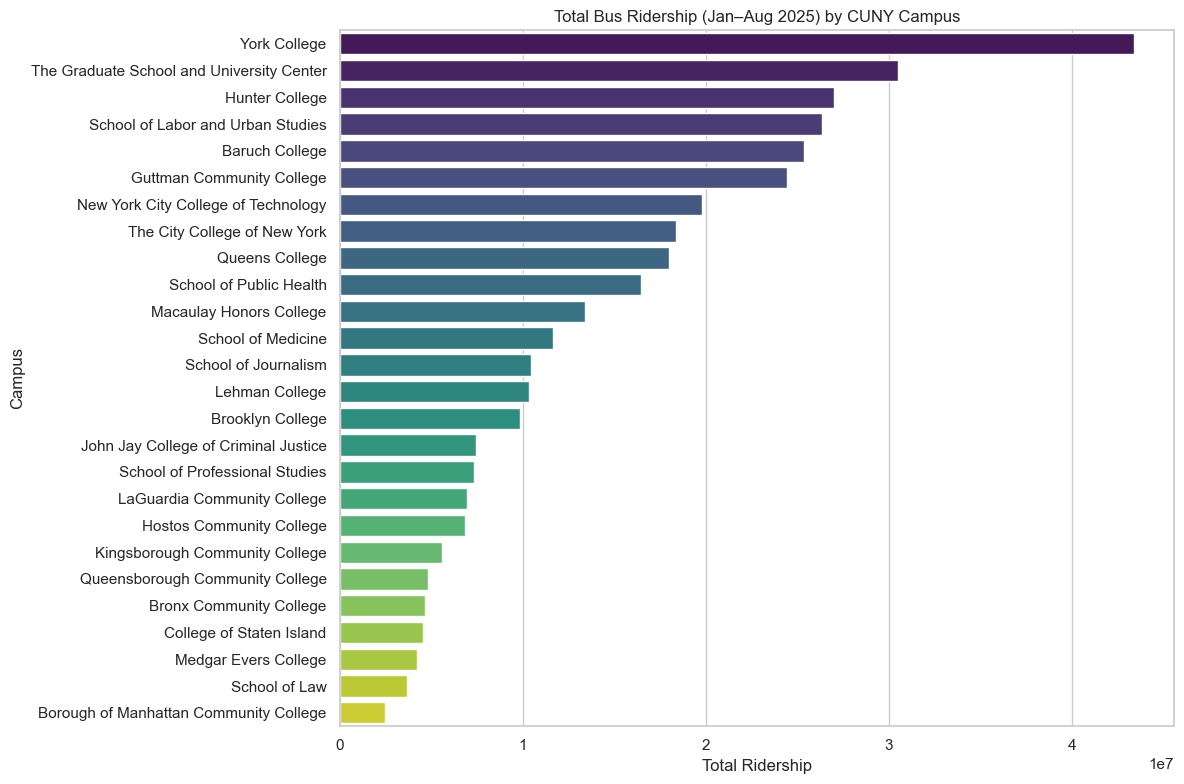

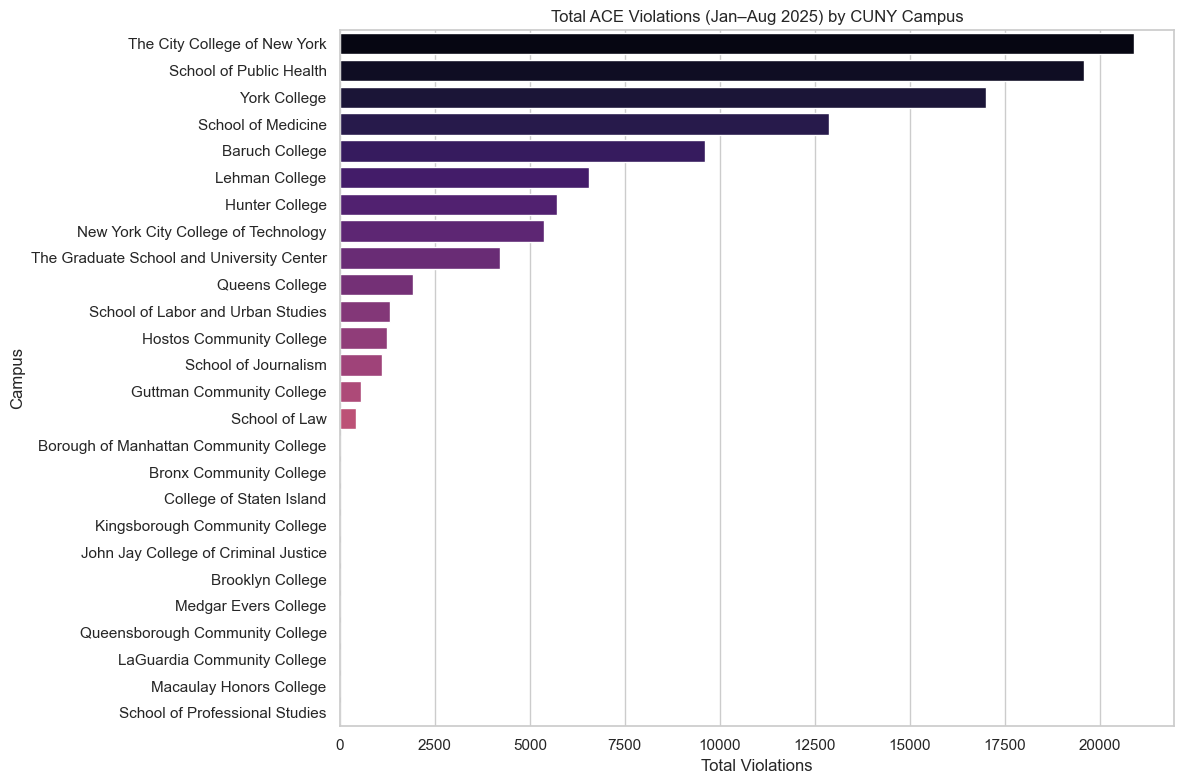

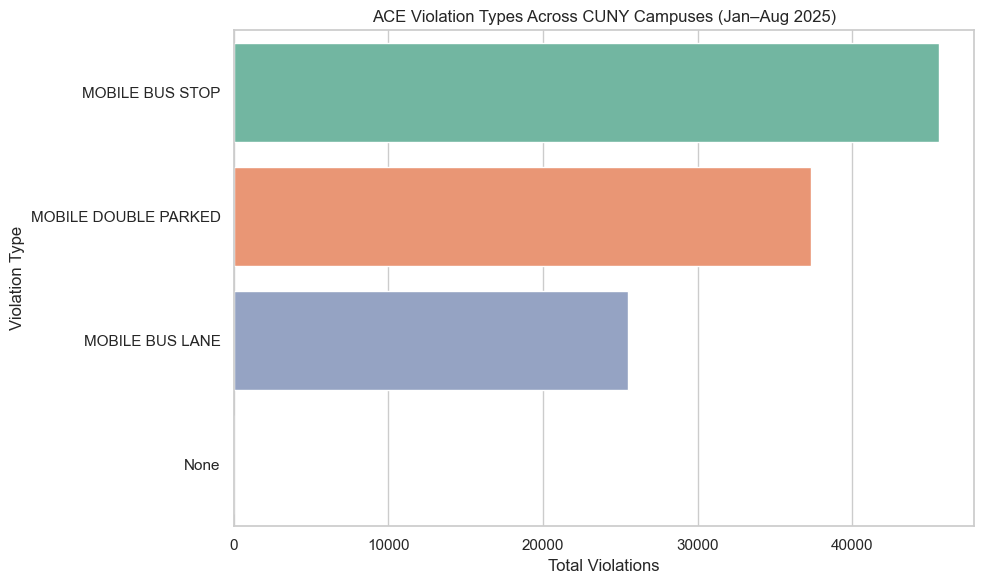

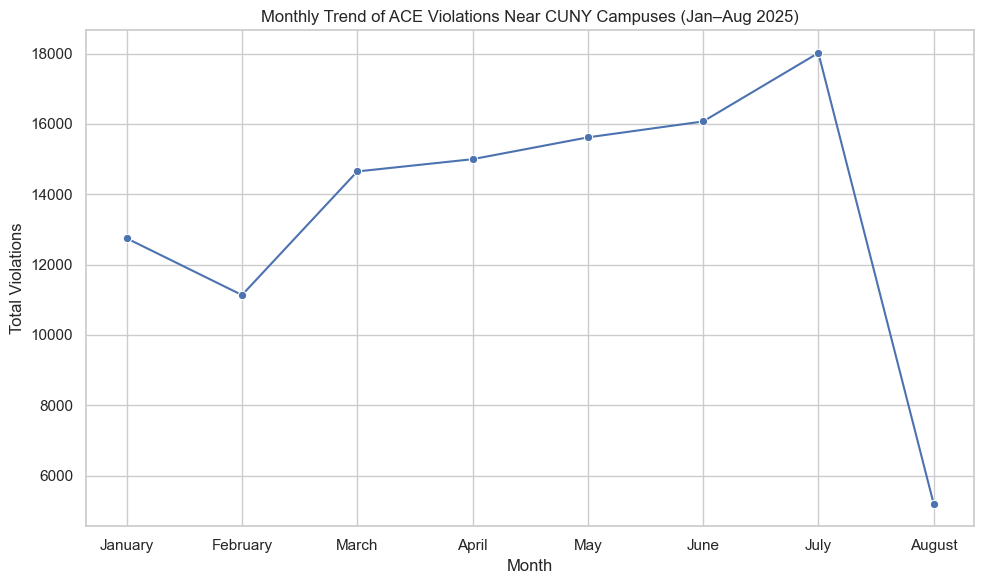

In [103]:
# 1. Top routes by ridership per campus
campus_ridership = (
    routes_per_campus.groupby("campus_name")
    .agg(total_ridership=("total_ridership", "sum"))
    .reset_index()
    .sort_values("total_ridership", ascending=False)
)

# export dataframe
campus_ridership.to_csv("../insights/campus_ridership_summary.csv", index=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=campus_ridership,
    x="total_ridership",
    y="campus_name",
    hue="campus_name",   # map to hue
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Total Bus Ridership (Jan–Aug 2025) by CUNY Campus")
plt.xlabel("Total Ridership")
plt.ylabel("Campus")
plt.tight_layout()
plt.show()

# 2. Violations per campus (all types)
campus_violations = (
    violations_per_campus.groupby("campus_name")
    .agg(total_violations=("violation_count", "sum"))
    .reset_index()
    .sort_values("total_violations", ascending=False)
)

# export
campus_violations.to_csv("../insights/campus_violations_summary.csv", index=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=campus_violations,
    x="total_violations",
    y="campus_name",
    hue="campus_name",
    dodge=False,
    palette="magma",
    legend=False
)
plt.title("Total ACE Violations (Jan–Aug 2025) by CUNY Campus")
plt.xlabel("Total Violations")
plt.ylabel("Campus")
plt.tight_layout()
plt.show()

# 3. Violation types across all campuses
violation_types = (
    violations_per_campus.groupby("Violation Type")
    .agg(total_violations=("violation_count", "sum"))
    .reset_index()
    .sort_values("total_violations", ascending=False)
)

# export
violation_types.to_csv("../insights/campus_violation_types_summary.csv", index=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=violation_types,
    x="total_violations",
    y="Violation Type",
    hue="Violation Type",
    dodge=False,
    palette="Set2",
    legend=False
)
plt.title("ACE Violation Types Across CUNY Campuses (Jan–Aug 2025)")
plt.xlabel("Total Violations")
plt.ylabel("Violation Type")
plt.tight_layout()
plt.show()

# 4. Time trend: violations by month
violations_month = (
    violations_per_campus.groupby("month")
    .agg(total_violations=("violation_count", "sum"))
    .reset_index()
)

# ensure months are ordered properly
month_order = ["January", "February", "March", "April", "May", "June", "July", "August"]
violations_month["month"] = pd.Categorical(violations_month["month"], categories=month_order, ordered=True)

# export
violations_month.to_csv("../insights/campus_violations_monthly_trend.csv", index=False)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=violations_month,
    x="month",
    y="total_violations",
    marker="o"
)
plt.title("Monthly Trend of ACE Violations Near CUNY Campuses (Jan–Aug 2025)")
plt.xlabel("Month")
plt.ylabel("Total Violations")
plt.tight_layout()
plt.show()

**Notes**
- Probably should normalize the data for each campus (e.g. if a school is bigger and has more students, it'll most likely show more violations)



**Recommendations**
- Use polygon footprint to have better spatial accuracy --> campus boundaries will be more precise therefore insights will be better
